In [2]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#for metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

from joblib import dump

In [3]:
df_data = pd.read_csv("../../generated_models/HFB_model/prottrans_t5_xlu50.csv")

df_hfb_1 = df_data[df_data["target"] == "HFB Class I"]
df_hfb_2 = df_data[df_data["target"] == "HFB Class II"]

df_data = pd.concat([df_hfb_1, df_hfb_2], axis=0)

In [4]:
response = df_data['target']
df_to_train = df_data.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(df_to_train, response, random_state=42, test_size=0.3)

svc_model = SVC(
    kernel= 'poly', 
    C= 0.05124561203590483, 
    degree= 4, 
    coef0= 4.147575647868992,
    probability=True
)

svc_model.fit(X=X_train, y=y_train)


SVC(C=0.05124561203590483, coef0=4.147575647868992, degree=4, kernel='poly',
    probability=True)

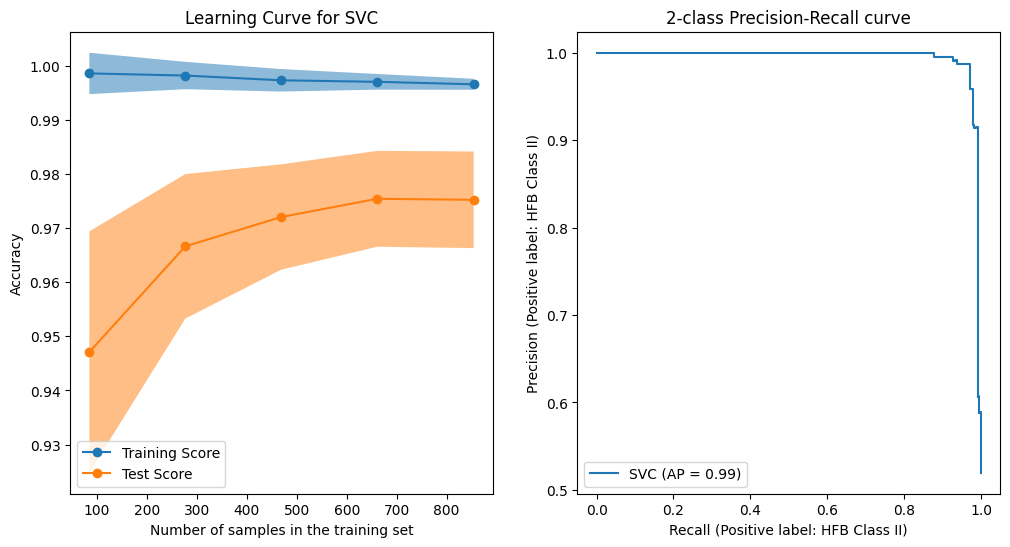

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(svc_model, **common_params, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {svc_model.__class__.__name__}")

display = PrecisionRecallDisplay.from_estimator(
    svc_model, X_test, y_test, name=svc_model.__class__.__name__, ax=ax[1])
_ = display.ax_.set_title("2-class Precision-Recall curve")


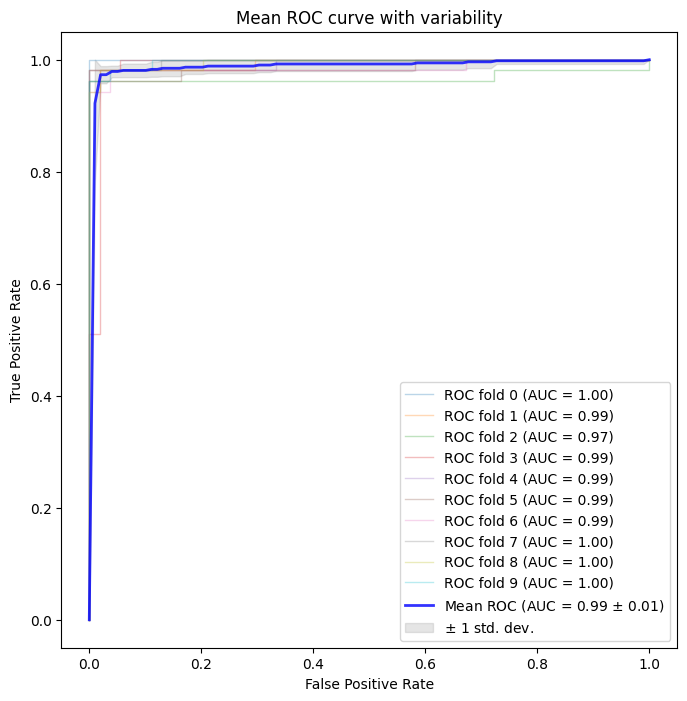

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    svc_model.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        svc_model,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")

In [7]:
dump(svc_model, "../../generated_models/HFB_model/svc_trained_model.joblib")

['../../generated_models/HFB_model/svc_trained_model.joblib']